In [ ]:
#hide
from chitra.core import *

<p align="center">
<img src="../assets/chitra_banner.png" alt="chitra">
</p>

# What is **chitra**?

**chitra** (**चित्र**) is an image utility library for Deep Learning tasks. *(It is not image-processing library)*

chitra reduces image data loading boilerplates for classification and object-detection.

It can also generate bounding-boxes from the annotated dataset.

If you have more use cases please [**raise an issue**](https://github.com/aniketmaurya/chitra/issues/new/choose) with the feature you want.

# Installation

## Using pip (recommended)

`pip install -U chitra`

## From source

```
git clone https://github.com/aniketmaurya/chitra.git
cd chitra
pip install -e .
```

# Usage

## Loading data for image classification



In [ ]:
import numpy as np
import tensorflow as tf
import chitra
from chitra.dataloader import Clf, show_batch
import matplotlib.pyplot as plt

CLASSES ENCODED: {'cat': 0, 'dog': 1}


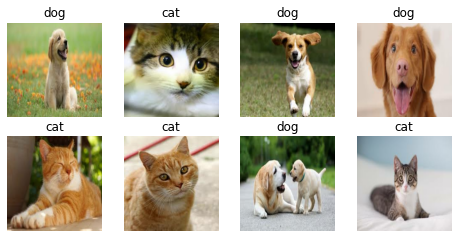

In [ ]:
path = '/Users/aniket/Pictures/data/train'

clf_dl = Clf()
data = clf_dl.from_folder(path, target_shape=(224, 224))

clf_dl.show_batch(8, figsize=(8,8))

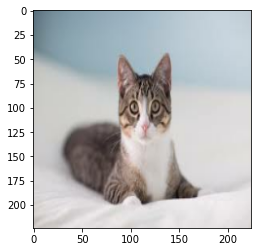

In [ ]:
for e in data.take(1):
    image = e[0].numpy().astype('uint8')
    label = e[1].numpy()
plt.imshow(image)
plt.show()

## Visualization

### Image annotation

Thanks to [**fizyr**](https://github.com/fizyr/keras-retinanet) keras-retinanet.

In [ ]:
from chitra.visualization import draw_annotations

labels = np.array([label])
bbox = np.array([[30, 50, 170, 190]])
label_to_name = lambda x: 'Cat' if x==0 else 'Dog'

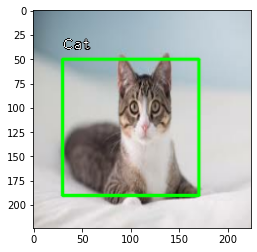

In [ ]:
draw_annotations(image, ({'bboxes': bbox, 'labels':labels,}), label_to_name=label_to_name)
plt.imshow(image)
plt.show()

# Contributing

Contributions of any kind are welcome. Please check the [**Contributing Guidelines**](https://github.com/aniketmaurya/chitra/blob/master/CONTRIBUTING.md) before contributing.